In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import copy

class MineralDataset(Dataset):
    def __init__(self, img_dir, labels_csv, transform=None):
        self.dataframe = pd.read_csv(labels_csv)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        file_name = row['Segmented Filename']
        label = row['Class']
        img_path = os.path.join(self.img_dir, file_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:

IMAGE_DIR = '/Mineral/CPX seg'
TRAIN_SPLIT_FILE = '/Mineral/train_split.csv'
VAL_SPLIT_FILE = '/Mineral/val_split.csv'

dataset_train = MineralDataset(
    img_dir=IMAGE_DIR,
    labels_csv=TRAIN_SPLIT_FILE,
    transform=transform_train
)

dataset_val = MineralDataset(
    img_dir=IMAGE_DIR,
    labels_csv=VAL_SPLIT_FILE,
    transform=transform_val
)

# batch size
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

In [ ]:
# modify the classifier of the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet34 = models.resnet34(pretrained=True)
for param in resnet34.parameters():
    param.requires_grad = False
num_ftrs = resnet34.fc.in_features
resnet34.fc = nn.Linear(num_ftrs, 3)
resnet34 = resnet34.to(device)

# loss function
labels = [label for _, label in dataset_train]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(resnet34.fc.parameters(), lr=0.0001)

def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=200, device='cuda'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

        val_loss = val_loss / len(val_loader.dataset)
        val_acc = val_corrects / len(val_loader.dataset)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return model, history

trained_model, training_history = train_and_evaluate_model(resnet34, train_loader, val_loader, criterion, optimizer, num_epochs=200, device=device)

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/200: Train Loss: 1.1358, Train Acc: 0.3834, Val Loss: 1.1357, Val Acc: 0.2705
Epoch 2/200: Train Loss: 1.0606, Train Acc: 0.4465, Val Loss: 1.0501, Val Acc: 0.5000
Epoch 3/200: Train Loss: 1.0065, Train Acc: 0.5345, Val Loss: 1.0013, Val Acc: 0.5342
Epoch 4/200: Train Loss: 0.9515, Train Acc: 0.6400, Val Loss: 0.9706, Val Acc: 0.5411
Epoch 5/200: Train Loss: 0.9284, Train Acc: 0.6327, Val Loss: 0.9400, Val Acc: 0.5856
Epoch 6/200: Train Loss: 0.8771, Train Acc: 0.6540, Val Loss: 0.9120, Val Acc: 0.6301
Epoch 7/200: Train Loss: 0.8652, Train Acc: 0.6972, Val Loss: 0.8948, Val Acc: 0.6678
Epoch 8/200: Train Loss: 0.8210, Train Acc: 0.7155, Val Loss: 0.8703, Val Acc: 0.6473
Epoch 9/200: Train Loss: 0.8242, Train Acc: 0.7023, Val Loss: 0.8642, Val Acc: 0.7089
Epoch 10/200: Train Loss: 0.8045, Train Acc: 0.6935, Val Loss: 0.8446, Val Acc: 0.7158
Epoch 11/200: Train Loss: 0.7721, Train Acc: 0.7698, Val Loss: 0.8289, Val Acc: 0.6918
Epoch 12/200: Train Loss: 0.7650, Train Acc: 0.7104,

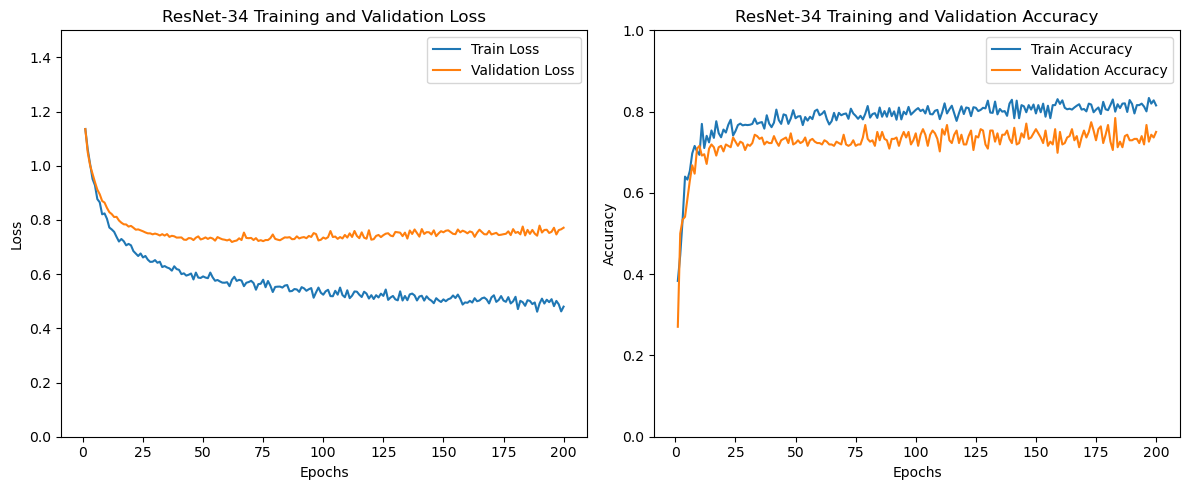

In [ ]:
import matplotlib.pyplot as plt
import torch
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    train_losses = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['train_loss']]
    val_losses = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['val_loss']]
    train_accs = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['train_acc']]
    val_accs = [x.cpu().numpy() if torch.is_tensor(x) else x for x in history['val_acc']]

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title('ResNet-34 Training and Validation Loss')
    plt.ylim(0, 1.5)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label='Train Accuracy')
    plt.plot(epochs, val_accs, label='Validation Accuracy')
    plt.title('ResNet-34 Training and Validation Accuracy')
    plt.ylim(0, 1)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()
plot_training_history(training_history)

# TEST SET

In [ ]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import copy
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt


transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

IMAGE_DIR = '/Mineral/CPX seg'
TEST_SPLIT_FILE = '/Mineral/test_split.csv'

test_dataset = MineralDataset(
    img_dir=IMAGE_DIR,
    labels_csv=TEST_SPLIT_FILE,
    transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load('/Mineral/Resnet.path')
model.to(device)
criterion = torch.nn.CrossEntropyLoss()

def evaluate_model(model, data_loader, criterion, device):
    model.eval()  
    all_labels = []
    all_losses = []

    with torch.no_grad():  
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            probabilities = torch.softmax(outputs, dim=1)
            all_probs.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
            all_losses.append(loss.cpu().numpy())

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    all_losses = np.array(all_losses)
    return all_probs, all_labels, all_losses

def bootstrap_metric(y_true, y_prob, metric_func, n_bootstrap=1000, alpha=0.05, **kwargs):
    rng = np.random.default_rng()
    indices = np.arange(len(y_true))
    bootstrapped_scores = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        if metric_func == roc_auc_score:
            score = metric_func(y_true[sample_indices], y_prob[sample_indices], **kwargs)
        else:
            y_pred = np.argmax(y_prob[sample_indices], axis=1)
            score = metric_func(y_true[sample_indices], y_pred, **kwargs)
        bootstrapped_scores.append(score)
    sorted_scores = np.sort(bootstrapped_scores)
    ci_lower = sorted_scores[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_scores[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_scores), ci_lower, ci_upper

def bootstrap_loss(losses, n_bootstrap=1000, alpha=0.05):
    rng = np.random.default_rng()
    indices = np.arange(len(losses))
    bootstrapped_losses = []
    for _ in range(n_bootstrap):
        sample_indices = rng.choice(indices, size=len(indices), replace=True)
        sample_loss = losses[sample_indices]
        bootstrapped_losses.append(np.mean(sample_loss))
    sorted_losses = np.sort(bootstrapped_losses)
    ci_lower = sorted_losses[int((alpha/2) * n_bootstrap)]
    ci_upper = sorted_losses[int((1 - alpha/2) * n_bootstrap)]
    return np.mean(bootstrapped_losses), ci_lower, ci_upper


test_probs, test_labels, test_losses = evaluate_model(model, test_loader, criterion, device)

class_labels = np.unique(test_labels)
metrics = {}
for class_label in class_labels:
    auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels == class_label, test_probs[:, class_label], roc_auc_score)
    balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: balanced_accuracy_score(y_true == class_label, y_pred == class_label))
    sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true == class_label, y_pred == class_label, zero_division=0))
    specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true == class_label, y_pred == class_label, zero_division=0))

    metrics[class_label] = {
        "AUC-ROC": (auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high),
        "Balanced Accuracy": (balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high),
        "Sensitivity": (sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high),
        "Specificity": (specificity_mean, specificity_ci_low, specificity_ci_high)
    }

print("Class\t\tAUC-ROC\t\t\tBalanced Accuracy\tSensitivity\t\tSpecificity")
for class_label, metric_values in metrics.items():
    auc_roc = metric_values["AUC-ROC"]
    balanced_acc = metric_values["Balanced Accuracy"]
    sensitivity = metric_values["Sensitivity"]
    specificity = metric_values["Specificity"]
    print(f"{class_label}\t\t{auc_roc[0]:.2f} ({auc_roc[1]:.2f}-{auc_roc[2]:.2f})\t"
          f"{balanced_acc[0]:.2f} ({balanced_acc[1]:.2f}-{balanced_acc[2]:.2f})\t"
          f"{sensitivity[0]:.2f} ({sensitivity[1]:.2f}-{sensitivity[2]:.2f})\t"
          f"{specificity[0]:.2f} ({specificity[1]:.2f}-{specificity[2]:.2f})")

auc_roc_mean, auc_roc_ci_low, auc_roc_ci_high = bootstrap_metric(test_labels, test_probs, roc_auc_score, multi_class='ovr')
balanced_acc_mean, balanced_acc_ci_low, balanced_acc_ci_high = bootstrap_metric(test_labels, test_probs, balanced_accuracy_score)
sensitivity_mean, sensitivity_ci_low, sensitivity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: recall_score(y_true, y_pred, average='macro', zero_division=0))
specificity_mean, specificity_ci_low, specificity_ci_high = bootstrap_metric(test_labels, test_probs, lambda y_true, y_pred: precision_score(y_true, y_pred, average='macro', zero_division=0))

loss_mean, loss_ci_low, loss_ci_high = bootstrap_loss(test_losses)

print(f"Overall\t\t{auc_roc_mean:.2f} ({auc_roc_ci_low:.2f}-{auc_roc_ci_high:.2f})\t"
      f"{balanced_acc_mean:.2f} ({balanced_acc_ci_low:.2f}-{balanced_acc_ci_high:.2f})\t"
      f"{sensitivity_mean:.2f} ({sensitivity_ci_low:.2f}-{sensitivity_ci_high:.2f})\t"
      f"{specificity_mean:.2f} ({specificity_ci_low:.2f}-{specificity_ci_high:.2f})")
print(f"Loss\t\t{loss_mean:.4f} ({loss_ci_low:.4f}-{loss_ci_high:.4f})")

Class		AUC-ROC			Balanced Accuracy	Sensitivity		Specificity
0		0.96 (0.94-0.98)	0.89 (0.85-0.93)	0.90 (0.83-0.96)	0.79 (0.71-0.86)
1		0.91 (0.87-0.94)	0.83 (0.79-0.87)	0.78 (0.71-0.84)	0.90 (0.85-0.95)
2		0.72 (0.62-0.82)	0.65 (0.56-0.75)	0.40 (0.22-0.59)	0.29 (0.15-0.43)
Overall		0.86 (0.82-0.91)	0.69 (0.63-0.76)	0.70 (0.62-0.77)	0.66 (0.60-0.72)
Loss		0.5930 (0.4756-0.7130)


In [ ]:
def get_predictions_and_labels(model, test_loader, device):

    predictions = []
    labels = []
    with torch.no_grad():
        for inputs, actuals in test_loader:
            inputs = inputs.to(device)
            actuals = actuals.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            labels.extend(actuals.cpu().numpy())
    return predictions, labels

test_predictions, test_labels = get_predictions_and_labels(trained_model, test_loader, device)


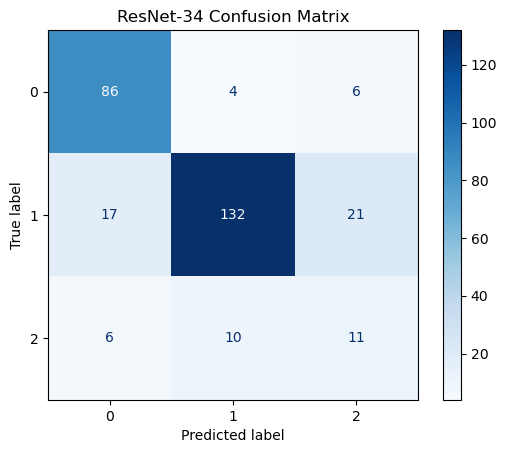

              precision    recall  f1-score   support

     Class 0       0.79      0.90      0.84        96
     Class 1       0.90      0.78      0.84       170
     Class 2       0.29      0.41      0.34        27

    accuracy                           0.78       293
   macro avg       0.66      0.69      0.67       293
weighted avg       0.81      0.78      0.79       293



In [ ]:
test_predictions, test_labels = get_predictions_and_labels(trained_model, test_loader, device)

cm = confusion_matrix(test_labels, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('ResNet-34 Confusion Matrix')
plt.show()

print(classification_report(test_labels, test_predictions, target_names=['Class 0', 'Class 1', 'Class 2']))


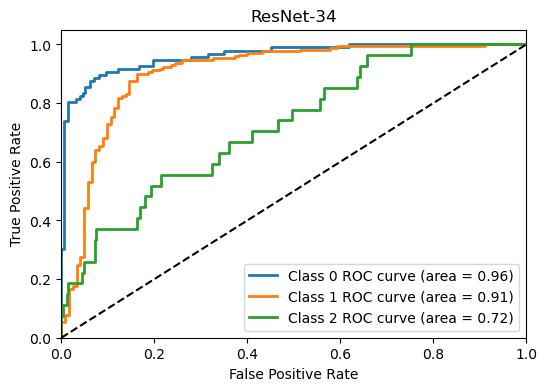

In [ ]:
def evaluate(model, data_loader, criterion, device):

    total = 0
    total_loss = 0.0
    all_probs = []  
    all_labels = [] 

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.append(probs.cpu())
            all_labels.extend(labels.cpu())
            total += labels.size(0)

    average_loss = total_loss / total
    return average_loss, torch.cat(all_probs).numpy(), np.array(all_labels)



def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(6, 4)):
    # Binarize the output
    y_test = label_binarize(y_test, classes=[*range(n_classes)])
    fpr = dict()
    tpr = dict()
    roc_auc = dict()


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=figsize)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ResNet-34')
    plt.legend(loc="lower right")
    plt.show()

test_loss, probs, true_labels = evaluate(trained_model, test_loader, criterion, device)


n_classes = 3
plot_multiclass_roc(true_labels, probs, n_classes)


In [ ]:
def get_predictions(model, data_loader, device):

    all_probs = []

    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_probs)


In [ ]:
def plot_prediction_histograms(probs, num_classes):
    plt.figure(figsize=(6, 4))

    cmap = plt.get_cmap('viridis')
    colors = [cmap(i) for i in np.linspace(0, 0.8, num_classes)]

    for i in range(num_classes):
        plt.hist(probs[:, i], bins=30, alpha=0.5, label=f'Class {i}', color=colors[i])

    plt.title('ResNet-34 Prediction Probability Distribution')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


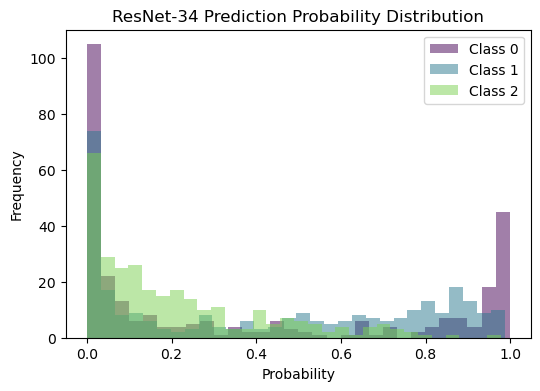

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trained_model.to(device)
test_probs = get_predictions(trained_model, test_loader, device)

num_classes = 3
plot_prediction_histograms(test_probs, num_classes)
